# APIs 

## Introducción

El dataset proviene de UCI LLamado 'adult', conocido también como Cesus Income dataset, predice si el ingreso anual de una persona puede exceder o no $50K, en este cuaderno se expone un modelo ml por una API, para desarrollarla se utilizará fastapi, para la ejecutar y entrenar el modelo se utiliza scikit-learn para posteriormente presentarlo a través de la API

In [1]:
from ucimlrepo import fetch_ucirepo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [2]:
adult = fetch_ucirepo(id=2) 
X = adult.data.features 
y = adult.data.targets 

Durante la primera etapa se tiene en cuenta la creación del modelo, según los datos historicos del mismo dataset se tienen en cuenta tres partes:
1. **Preprocesamiento** cargar los datos, lipiar la base y transformar variables categoricas en numéricas 
2. **Entrenamiento** : para el entrenamiento se utilizará el modelo RandomForestClassifier, que representa la union de multiples arboles de decisión para así seleccionar el mejor
3. **predicción**: Posteriormente se presenta la predicción a través de una API

En este caso como mi variable objetivo es el ingreso o Income la cual es la deseo predecir y las demás variables son predictoras.

### Carga del Dataset

In [3]:
df = pd.DataFrame(X, columns=adult.variables.name[:-1])
df['Income'] = y
df.head(3)

name,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [4]:
### Análisis exploratorio de datos

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  Income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [5]:
### Análisis de valores nulos

df.isnull().sum()

name
age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
Income              0
dtype: int64

In [6]:
### Análisis de valores duplicados

# Verificación de valores duplicados

df=df.drop_duplicates()
df.head(3)

name,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [8]:
### Arreglo de la variable objetivo

df['Income'] = df['Income'].replace({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})
df['Income'].value_counts()

Income
0    37128
1    11685
Name: count, dtype: int64

In [9]:
### Análisis de las variables numéricas

df.describe()

name,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,Income
count,48813.000000,4.881300e+04,48813.000000,48813.000000,48813.000000,48813.000000,48813.000000
mean,38.647348,1.896679e+05,10.078688,1079.708705,87.554299,40.425051,0.239383
std,13.709005,1.056062e+05,2.570257,7454.185982,403.118605,12.390954,0.426711
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.175550e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.781400e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.376200e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [10]:
### Análisis de las variables categóricas

# Estadísticas descriptivas de las variables categóricas

df.describe(include='object')

name,workclass,education,marital-status,occupation,relationship,race,sex,native-country
count,47850,48813,48813,47847,48813,48813,48813,48539
unique,9,16,7,15,6,5,2,42
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,33879,15777,22372,6167,19709,41736,32631,43810


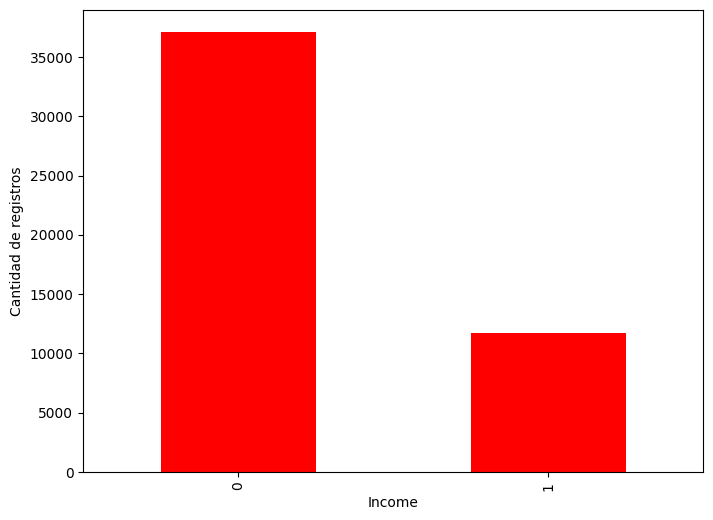

In [11]:
### Visualización de la variable objetivo

# Gráfico de barras de la variable objetivo

plt.figure(figsize=(8, 6))

plt.xlabel('Ingresos')
plt.ylabel('Cantidad de registros')
df['Income'].value_counts().plot(kind='bar', color ="red")
plt.show()

Text(0.5, 1.0, 'Sex Vs Income')

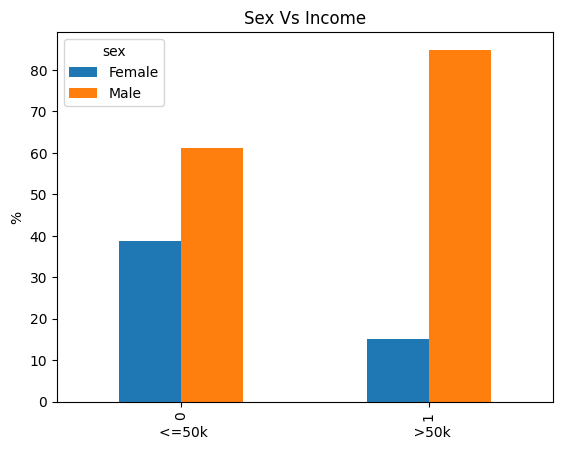

In [16]:
table_income_sex = pd.crosstab(df['Income'], df['sex'], normalize='index')*100.
table_income_sex.plot(kind='bar')
plt.ylabel("%")
plt.xlabel("<=50k                                               >50k")
plt.title("Sex Vs Income")

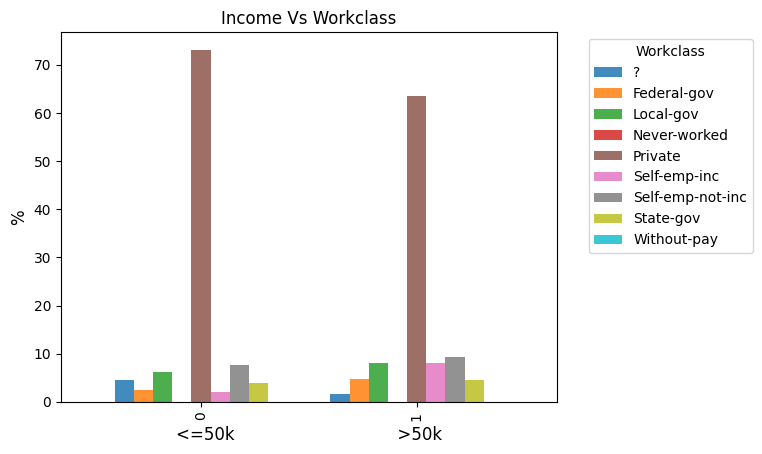

In [27]:
ct_income_workclass = pd.crosstab(df['Income'], df['workclass'], normalize='index')*100
ct_income_workclass.plot(kind='bar', width=0.8, cmap="tab10", alpha=0.85)
plt.ylabel("%", fontsize=12)

plt.xlabel("<=50k                               >50k", fontsize=12)
plt.title('Income Vs Workclass')
plt.legend(title="Workclass", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)





In [28]:
### tratamiento de variables 

# Transformación de las variables categóricas

df['workclass'].value_counts()

workclass
Private             33879
Self-emp-not-inc     3861
Local-gov            3136
State-gov            1981
?                    1836
Self-emp-inc         1694
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64

In [71]:
#### preprocesamiento de datos



# Separación de las variables predictoras y la variable objetivo

X = df.drop('Income', axis=1)
y = df['Income']

print(X.info())


<class 'pandas.core.frame.DataFrame'>
Index: 48813 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48813 non-null  int64 
 1   workclass       47850 non-null  object
 2   fnlwgt          48813 non-null  int64 
 3   education       48813 non-null  object
 4   education-num   48813 non-null  int64 
 5   marital-status  48813 non-null  object
 6   occupation      47847 non-null  object
 7   relationship    48813 non-null  object
 8   race            48813 non-null  object
 9   sex             48813 non-null  object
 10  capital-gain    48813 non-null  int64 
 11  capital-loss    48813 non-null  int64 
 12  hours-per-week  48813 non-null  int64 
 13  native-country  48539 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.6+ MB
None


In [112]:
### En X buscamos las columnas categoricas y las numericas

# Identificación de las columnas numéricas y categóricas

columnas_numericas = X.select_dtypes(exclude='object').columns
columnas_numericas

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

In [113]:
columnas_categoricas = X.select_dtypes(include='object').columns
columnas_categoricas

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')

In [114]:
### Definimos los pasos para el preprocesamiento de los datos

transfomacion_OHE = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

### Ejemplo de uso

print(transfomacion_OHE.fit_transform(X[['workclass']]))

print(transfomacion_OHE.fit_transform(X[columnas_categoricas]).shape)



[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(48842, 105)


In [115]:
### SimpleImputer

transformacion_nan= SimpleImputer(strategy='constant', fill_value='Desconocido')

pd.DataFrame(transformacion_nan.fit_transform(X[['occupation']])).value_counts()

0                
Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
?                    1843
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Desconocido           966
Priv-house-serv       242
Armed-Forces           15
Name: count, dtype: int64

In [116]:
### Normalización de las variables numéricas

transformacion_escalar = StandardScaler()

pd.DataFrame(transformacion_escalar.fit_transform(X[columnas_numericas])).describe()

,0,1,2,3,4,5
count,4.884200e+04,4.884200e+04,4.884200e+04,4.884200e+04,4.884200e+04,4.884200e+04
mean,2.275273e-16,-5.644539e-17,-9.019624e-17,1.018345e-17,-9.892491e-18,4.568003e-17
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00
min,-1.578629e+00,-1.679680e+00,-3.531030e+00,-1.448035e-01,-2.171271e-01,-3.181452e+00
25%,-7.763164e-01,-6.828752e-01,-4.193353e-01,-1.448035e-01,-2.171271e-01,-3.408696e-02
50%,-1.198790e-01,-1.090844e-01,-3.037346e-02,-1.448035e-01,-2.171271e-01,-3.408696e-02
75%,6.824334e-01,4.543232e-01,7.475502e-01,-1.448035e-01,-2.171271e-01,3.694214e-01
max,3.745808e+00,1.231723e+01,2.303397e+00,1.327438e+01,1.059179e+01,4.727312e+00


In [86]:
### Transformación de las variables
from sklearn.pipeline import Pipeline

# Creación de los pasos para el preprocesamiento

pasos = [
    ('imputacion', transformacion_nan),
    ('codificacion', transfomacion_OHE),]

# Creación del preprocesador

preprocesador_categorical = ColumnTransformer(
    transformers=[('CAT',Pipeline(pasos), columnas_categoricas)])

preprocsador_numerico = ColumnTransformer(
    transformers=[('escalar', transformacion_escalar, columnas_numericas)])


Transformacion_Columnas = ColumnTransformer(
    transformers=[
        ('num', preprocsador_numerico, columnas_numericas),
        ('cat', preprocesador_categorical, columnas_categoricas)
    ])

Transformacion_Columnas.fit(X)

pd.DataFrame(Transformacion_Columnas.transform(X)).head()

,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,110
0,0.025996,-1.061979,1.136512,0.146932,-0.217127,-0.034087,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.828308,-1.007104,1.136512,-0.144804,-0.217127,-2.213032,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.046942,0.246034,-0.419335,-0.144804,-0.217127,-0.034087,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.047121,0.426663,-1.197259,-0.144804,-0.217127,-0.034087,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.776316,1.408530,1.136512,-0.144804,-0.217127,-0.034087,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
import joblib 

joblib.dump(Transformacion_Columnas, 'preprocesador.gz')

['preprocesador.gz']

In [88]:
new_column_transformer = joblib.load('preprocesador.gz')
new_column_transformer


ColumnTransformer(transformers=[('num',
                                 ColumnTransformer(transformers=[('escalar',
                                                                  StandardScaler(),
                                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object', name='name'))]),
                                 Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object', name='name')),
                                ('cat',
                                 ColumnTransf...
                                                                                  ('codificacion',
                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                 sparse_output=False))]),
                                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object', name='name'))]),
                                 Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object', name='name'))])

In [117]:
columnas_numericas=Transformacion_Columnas.transformers_[0][2]
columnas_numericas

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object', name='name')

In [90]:
columnas_categoricas_transformadas=Transformacion_Columnas.named_transformers_['cat'].named_transformers_['CAT'][-1].get_feature_names_out()


columnas_categoricas_transformadas

array(['x0_?', 'x0_Desconocido', 'x0_Federal-gov', 'x0_Local-gov',
       'x0_Never-worked', 'x0_Private', 'x0_Self-emp-inc',
       'x0_Self-emp-not-inc', 'x0_State-gov', 'x0_Without-pay', 'x1_10th',
       'x1_11th', 'x1_12th', 'x1_1st-4th', 'x1_5th-6th', 'x1_7th-8th',
       'x1_9th', 'x1_Assoc-acdm', 'x1_Assoc-voc', 'x1_Bachelors',
       'x1_Doctorate', 'x1_HS-grad', 'x1_Masters', 'x1_Preschool',
       'x1_Prof-school', 'x1_Some-college', 'x2_Divorced',
       'x2_Married-AF-spouse', 'x2_Married-civ-spouse',
       'x2_Married-spouse-absent', 'x2_Never-married', 'x2_Separated',
       'x2_Widowed', 'x3_?', 'x3_Adm-clerical', 'x3_Armed-Forces',
       'x3_Craft-repair', 'x3_Desconocido', 'x3_Exec-managerial',
       'x3_Farming-fishing', 'x3_Handlers-cleaners',
       'x3_Machine-op-inspct', 'x3_Other-service', 'x3_Priv-house-serv',
       'x3_Prof-specialty', 'x3_Protective-serv', 'x3_Sales',
       'x3_Tech-support', 'x3_Transport-moving', 'x4_Husband',
       'x4_Not-in-family'

In [91]:
### Entrenamos varios modelos random forest para decidir si una persona gana mas de 50k y escogeremos el mejor modelo.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Separación de los datos en entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creación del modelo

parametros = {'n_estimators': [100, 200, 500],
                'max_depth': [5, 10,  20],
                'min_samples_split': [5, 10,  20],
                'min_samples_leaf': [1, 2, 10]}

modelo = RandomForestClassifier(random_state=42)


# Búsqueda de los mejores hiperparámetros

grid = GridSearchCV(modelo, param_grid=parametros, cv=5, n_jobs=-1)

grid.fit(Transformacion_Columnas.transform(X_train), y_train)

c:\Users\aljur\anaconda3\envs\newenvincome\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [1, 2, 10],
                         'min_samples_split': [5, 10, 20],
                         'n_estimators': [100, 200, 500]})

In [118]:
## Evaluación del modelo

best_model = grid.best_estimator_
print('Mejores hiperparámetros:', grid.best_params_)

## Predicciones
y_pred = best_model.predict(Transformacion_Columnas.transform(X_test))

print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))

Mejores hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 200}
Accuracy: 0.5963966423258036

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.60      0.96      0.73      7380
      <=50K.       0.92      0.08      0.15      3729
        >50K       0.55      0.57      0.56      2382
       >50K.       0.80      0.02      0.04      1162

    accuracy                           0.60     14653
   macro avg       0.71      0.41      0.37     14653
weighted avg       0.69      0.60      0.50     14653


Confusion Matrix:
 [[7049    2  329    0]
 [3242  314  168    5]
 [1027    2 1352    1]
 [ 492   25  621   24]]


In [119]:
### Guardamos el mejor modelo

joblib.dump(best_model, 'mejor_modelo.gz')

### Crear un pipeline para preprocesar los datos, entrenar el modelo y predecir nuevos datos

from sklearn.pipeline import Pipeline

# Creación del pipeline

pipeline = Pipeline(steps=[('preprocesador', Transformacion_Columnas),
                            ('modelo', best_model)])

# Entrenamiento del pipeline

pipeline.fit(X_train, y_train)

# Predicción de nuevos datos

nuevos_datos = X_test[:5]

pipeline.predict(nuevos_datos)



c:\Users\aljur\anaconda3\envs\newenvincome\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


array(['<=50K', '<=50K', '<=50K', '<=50K', '<=50K'], dtype=object)

In [120]:
pipeline

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  ColumnTransformer(transformers=[('escalar',
                                                                                   StandardScaler(),
                                                                                   Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object', name='name'))]),
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object',...
                                                                                   Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object', name='name'))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object', name='name'))])),
                ('modelo',
                 RandomForestClassifier(max_depth=20, min_samples_split=20,
                                        n_estimators=200, random_state=42))])

In [121]:
### Guardamos el pipeline

joblib.dump(pipeline, 'pipeline_total.gz')


['pipeline_total.gz']

In [96]:
nuevos_datos.to_json()

'{"age":{"7762":18,"23881":17,"30507":25,"28911":20,"19484":47},"workclass":{"7762":"Private","23881":"Private","30507":"Local-gov","28911":"Private","19484":"Private"},"fnlwgt":{"7762":423024,"23881":178953,"30507":348986,"28911":218215,"19484":244025},"education":{"7762":"HS-grad","23881":"12th","30507":"HS-grad","28911":"Some-college","19484":"HS-grad"},"education-num":{"7762":9,"23881":8,"30507":9,"28911":10,"19484":9},"marital-status":{"7762":"Never-married","23881":"Never-married","30507":"Never-married","28911":"Never-married","19484":"Never-married"},"occupation":{"7762":"Other-service","23881":"Sales","30507":"Handlers-cleaners","28911":"Sales","19484":"Machine-op-inspct"},"relationship":{"7762":"Not-in-family","23881":"Own-child","30507":"Other-relative","28911":"Own-child","19484":"Unmarried"},"race":{"7762":"White","23881":"White","30507":"Black","28911":"White","19484":"Amer-Indian-Eskimo"},"sex":{"7762":"Male","23881":"Female","30507":"Male","28911":"Female","19484":"Male